# Brain Tumor Detection with ResNet50 and Custom Preprocessing
Ova bilježnica prikazuje detekciju tumora mozga na MRI slikama korištenjem transfer learninga (ResNet50) i vlastitog skupa podataka BinaryBrainTumorDataset.

## 1. Uvod i ciljevi
Cilj je izgraditi model koji klasificira MRI slike na tumorske i netumorske koristeći transfer learning s ResNet50 arhitekturom. Skup podataka: `BinaryBrainTumorDataset` s dvije klase: "yes" (tumor) i "no" (bez tumora).

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns

## 2. Učitavanje i raspodjela podataka
Učitavamo slike iz direktorija, raspodjeljujemo ih na train, validation i test skupove.

In [3]:
IMG_SIZE = (224, 224)
DATASET_DIR = "../data/BinaryBrainTumorDataset/Training"
TEST_DIR = "../data/BinaryBrainTumorDataset/Testing"

def load_images_from_folder(folder, label, img_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

X = []
y = []
for class_name in ["yes", "no"]:
    imgs, labels = load_images_from_folder(os.path.join(DATASET_DIR, class_name), 1 if class_name == "yes" else 0, IMG_SIZE)
    X.extend(imgs)
    y.extend(labels)

X = np.array(X)
y = np.array(y)

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## 3. Vizualizacija podataka
Prikaz nekoliko slika iz obje klase.

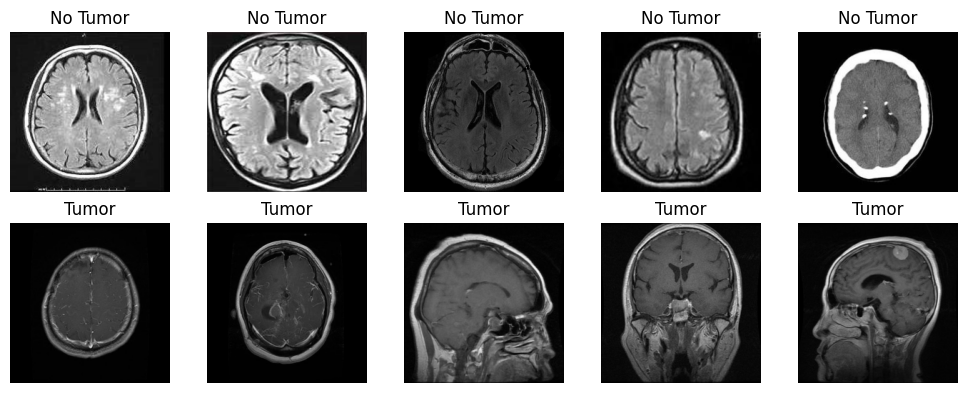

In [4]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[y_train == 0][i])
    plt.title("No Tumor")
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(X_train[y_train == 1][i])
    plt.title("Tumor")
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4. Predobrada: automatsko croppanje mozga
Koristi se kontura za izrezivanje regije mozga iz slike.

In [ ]:
def crop_brain(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return img
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    cropped = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    cropped = cv2.resize(cropped, IMG_SIZE)
    return cropped

X_train_crop = np.array([crop_brain(img) for img in X_train])
X_val_crop = np.array([crop_brain(img) for img in X_val])

## 5. Augmentacija i priprema podataka za ResNet50
Koristi se ImageDataGenerator za augmentaciju i ResNet50 predobradu.

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
    X_train, y_train, batch_size=16, shuffle=True
)
val_generator = val_datagen.flow(
    X_val, y_val, batch_size=16, shuffle=False
)

## 6. Model: Transfer learning s ResNet50
Koristi se ResNet50 bez gornjeg sloja, dodaju se vlastiti klasifikacijski slojevi.

In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = True

model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

I0000 00:00:1750172939.273806  220919 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3880 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 24,059,393 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 7. Treniranje modela

In [ ]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_resnet_brain_model.keras", save_best_only=True, monitor="val_accuracy")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

/home/josip/Desktop/zavrsni rad/MRI-Image-Classification-for-Brain-Tumor-Detection-/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1750172979.222909  221021 service.cc:152] XLA service 0x73bc44003390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750172979.222932  221021 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-06-17 17:09:39.693438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750172982.207608  221021 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-17 17:09:43.739699: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16349', 4 bytes spill stores, 4 bytes spill loads

2025-06-17 17:09:44.016721: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion

  1/250 ━━━━━━━━━━━━━━━━━━━━ 2:21:09 34s/step - accuracy: 0.3750 - loss: 0.8512

I0000 00:00:1750172998.940367  221021 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/250 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7554 - loss: 0.4671

2025-06-17 17:10:22.760312: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16349', 12 bytes spill stores, 12 bytes spill loads

2025-06-17 17:10:23.069073: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16349', 112 bytes spill stores, 112 bytes spill loads

2025-06-17 17:10:23.358943: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16349', 8 bytes spill stores, 8 bytes spill loads

2025-06-17 17:10:23.363018: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16349', 8 bytes spill stores, 8 bytes spill loads

2025-06-17 17:10:23.699142: I external

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8089 - loss: 0.3851

2025-06-17 17:11:02.982751: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1690', 12 bytes spill stores, 12 bytes spill loads

2025-06-17 17:11:03.068046: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1690', 8 bytes spill stores, 8 bytes spill loads

2025-06-17 17:11:03.251170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1690', 8 bytes spill stores, 8 bytes spill loads

2025-06-17 17:11:03.278992: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1690', 112 bytes spill stores, 112 bytes spill loads

2025-06-17 17:11:03.631628: I external/loc

250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 269ms/step - accuracy: 0.8092 - loss: 0.3844 - val_accuracy: 0.9714 - val_loss: 0.0877
Epoch 2/30
 73/250 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.9719 - loss: 0.0883

## 8. Evaluacija modela
Prikaz točnosti, gubitka, ROC krivulje i matrice zabune.

In [ ]:
# Evaluacija na validation skupu
val_preds = model.predict(val_generator)
val_preds_bin = (val_preds > 0.5).astype(int).flatten()
accuracy = accuracy_score(y_val, val_preds_bin)
cm = confusion_matrix(y_val, val_preds_bin)
fpr, tpr, _ = roc_curve(y_val, val_preds)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Accuracy
axes[0, 0].plot(history.history["accuracy"], label="Train")
axes[0, 0].plot(history.history["val_accuracy"], label="Val")
axes[0, 0].set_title("Accuracy")
axes[0, 0].legend()
# Loss
axes[0, 1].plot(history.history["loss"], label="Train")
axes[0, 1].plot(history.history["val_loss"], label="Val")
axes[0, 1].set_title("Loss")
axes[0, 1].legend()
# ROC Curve
axes[1, 0].plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
axes[1, 0].plot([0, 1], [0, 1], "k--")
axes[1, 0].set_title("ROC Curve")
axes[1, 0].legend()
# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"], ax=axes[1, 1])
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")
axes[1, 1].set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")
print(classification_report(y_val, val_preds_bin, target_names=["No Tumor", "Tumor"]))

plt.figure(figsize=(8, 4))
print(f"Tocnost (accuracy): {accuracy:.4f}")
report_dict = classification_report(y_val, val_preds_bin, target_names=["no", "yes"], output_dict=True)
print(f"Preciznost (precision): {report_dict['weighted avg']['precision']:.4f}")
print(f"F1 rezultat: {report_dict['weighted avg']['f1-score']:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

## 9. Zaključak
Model temeljen na ResNet50 i vlastitoj predobradi daje dobre rezultate na zadatku detekcije tumora mozga. Daljnja poboljšanja mogu uključivati finetuning, proširenje skupa podataka i naprednije augmentacije.